# Gradient Matching Attack on a TF Classifier

In this notebook, we will learn how to use ART to run a clean-label gradient matching poisoning attack on a neural network trained with Tensorflow. We will be training our data on a subset of the CIFAR-10 dataset. The methods described are derived from [this paper](https://arxiv.org/abs/2009.02276) by Geiping, et. al. 2020.

## Train a model to attack

In this example, we use a RESNET50 model on the CIFAR dataset.

In [1]:
import numpy as np
import os, sys

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_cifar10

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# x_train = x_train[0:50000]
# y_train = y_train[0:50000]
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

min_ = (min_-mean)/(std+1e-7)
max_ = (max_-mean)/(std+1e-7)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_model(x_train, y_train, num_classes=10, batch_size=64, epochs=25):
    model = Sequential([
        tf.keras.applications.ResNet50(input_shape=x_train.shape[1:], include_top=False, weights=None),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
    datagen.fit(x_train)
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,verbose=1)
    return model

model = create_model(x_train, y_train, epochs=25)
model_art = TensorFlowV2Classifier(model, nb_classes=10, input_shape=model.input_shape)

Epoch 1/25
781/781 [==============================] - 30s 31ms/step - loss: 2.3486 - accuracy: 0.3187
Epoch 2/25
781/781 [==============================] - 24s 30ms/step - loss: 1.9252 - accuracy: 0.4055
Epoch 3/25
781/781 [==============================] - 24s 30ms/step - loss: 1.7595 - accuracy: 0.4497
Epoch 4/25
781/781 [==============================] - 24s 30ms/step - loss: 1.6777 - accuracy: 0.4794
Epoch 5/25
781/781 [==============================] - 23s 30ms/step - loss: 1.5766 - accuracy: 0.5016
Epoch 6/25
781/781 [==============================] - 24s 30ms/step - loss: 1.5179 - accuracy: 0.5230
Epoch 7/25
781/781 [==============================] - 24s 30ms/step - loss: 1.4922 - accuracy: 0.5297
Epoch 8/25
781/781 [==============================] - 24s 31ms/step - loss: 1.3962 - accuracy: 0.5563
Epoch 9/25
781/781 [==============================] - 24s 30ms/step - loss: 1.3707 - accuracy: 0.5680
Epoch 10/25
781/781 [==============================] - 24s 30ms/step - loss: 1.543

## Choose Target Image from Test Set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(80, 80, 3)


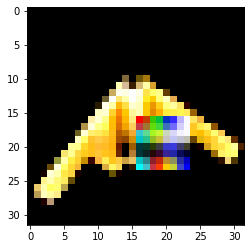

In [2]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.transform import resize

# # A trigger from class 0 will be classified into class 1.
class_source = 0
class_target = 1
# Select a random example for target
index_target = np.where(y_test.argmax(axis=1)==class_source)[0][5]

img = Image.open('trigger_10.png')

# PIL images into NumPy arrays
numpydata = asarray(img)
print(numpydata.shape)
p = resize(numpydata, (8,8,3))
# print(numpydata.shape)
  

# Trigger sample
# We can select any random trigger as per the paper
x_trigger = x_test[index_target:index_target+1]
# Will the position of tigger matter?????????????? RESEARCH QUESTIONS [Need to make this random]
x_trigger[:,16:24,16:24,:] = p
plt.imshow(x_trigger[0])
y_trigger  = to_categorical([class_target], num_classes=10)

## Poison Training Images to Misclassify the Trigger Image


In [ ]:
from art.attacks.poisoning.gradient_matching_attack import GradientMatchingAttack

epsilson = 0.1/(std+1e-7)

attack = GradientMatchingAttack(model_art,
        percent_poison=0.01,
        max_trials=1,
        max_epochs=200,
        clip_values=(min_,max_),
        epsilon=epsilson,
        verbose=False,
        selection_strategy = "max_grad_norm",
        retraining_factor = 4,  
        retrain_epoch = 25)                        

x_poison, y_poison = attack.poison(x_trigger, y_trigger, x_train, y_train)


self.substitute_classifier.model.trainable True
shape of y_train_classes [6 9 9 ... 9 1 1]
shape of y_train (50000, 10)
shape of x_trigger (1, 32, 32, 3)
shape of y_trigger (1, 10)


  0%|          | 0/1 [00:00<?, ?it/s]

## Examples of the trigger, an original sample, and the poisoned sample

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_trigger[0])
plt.title('Trigger image')
plt.show()


plt.imshow(x_trigger[0]*(std+1e-7)+mean)
plt.title('Trigger image')
plt.show()

index_poisoned_example = np.where([np.any(p!=o) for (p,o) in zip(x_poison,x_train)])[0]
plt.imshow(x_train[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Original image')
plt.show()

plt.imshow(x_poison[index_poisoned_example[0]]*(std+1e-7)+mean)
plt.title('Poisoned image')
plt.show()


## Training with Poison Images

These attacks allow adversaries who can poison your dataset the ability to mislabel any particular target instance of their choosing without manipulating labels.

In [ ]:
model_poisoned = create_model(x_poison, y_poison, epochs=25)
y_ = model_poisoned.predict(x_trigger)

print("y_trigger:", y_trigger)
print("y_:", np.argmax(y_))